## Installation

In [1]:
%pip install torch soundfile transformers rouge-score matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports and Whisper model

In [2]:
import os
import torch
import soundfile as sf
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v2"
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

model.safetensors:  79%|#######8  | 4.88G/6.17G [00:00<?, ?B/s]

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--openai--whisper-large-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


generation_config.json:   0%|          | 0.00/4.29k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
# Function to transcribe audio
def transcribe_audio(file_path,output_file):
    audio_input, sample_rate = sf.read(file_path)
    result = pipe({"array": audio_input, "sampling_rate": sample_rate})
    transcription = " ".join([chunk['text'] for chunk in result["chunks"]])

    file_name = os.path.basename(file_path).replace('.wav', '')
    
    with open(output_file, 'a', encoding = 'utf-8') as file:
        file.write(f"{file_name} {transcription}\n")
    

    return transcription

# Function to read reference transcriptions 
def read_reference_transcriptions(file_path):
    references = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                file_id, transcript = parts
                references[file_id] = transcript
    print(references)
    
    return references

# Function to process all audio files
def process_audio_files(audio_folder,  output_file):
    transcriptions = []

    for file_name in os.listdir(audio_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_folder, file_name)
            transcription = transcribe_audio(file_path, output_file)
            transcriptions.append(transcription)


    


## Generate transcriptions for first experiment

In [26]:

audio_folder = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\wavFiles"  
output_file = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\wavFiles\\TranscriptObtained.txt"

process_audio_files(audio_folder, output_file)

In [45]:
# Function to evaluate ROUGE scores
def evaluate_rouge_scores(transcriptions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(ref.lower(), trans.lower()) for ref, trans in zip(references, transcriptions)]

    rouge1_scores = [score['rouge1'].fmeasure for score in scores]
    rouge2_scores = [score['rouge2'].fmeasure for score in scores]
    rougeL_scores = [score['rougeL'].fmeasure for score in scores]

    avg_rouge1_score = np.mean(rouge1_scores)
    avg_rouge2_score = np.mean(rouge2_scores)
    avg_rougeL_score = np.mean(rougeL_scores)

    print("Average ROUGE-1 F1 score:", avg_rouge1_score)
    print("Average ROUGE-2 F1 score:", avg_rouge2_score)
    print("Average ROUGE-L F1 score:", avg_rougeL_score)

    # Create a bar plot with the average scores
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    avg_scores = [avg_rouge1_score, avg_rouge2_score, avg_rougeL_score]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x, avg_scores, width, label='Speech Recognition')

    ax.set_ylabel('Scores')
    ax.set_title('Average performance scores for speech recognition')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Function to read transcriptions from text files
def read_transcriptions(file_path):
    transcriptions = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            transcript = line.strip().split(' ', 1)[1].strip().lower()  # Obtener solo la transcripción y convertir a minúsculas
            transcriptions.append(transcript)
    return transcriptions


Average ROUGE-1 F1 score: 0.9194904176627019
Average ROUGE-2 F1 score: 0.8610947626219396
Average ROUGE-L F1 score: 0.9194904176627019


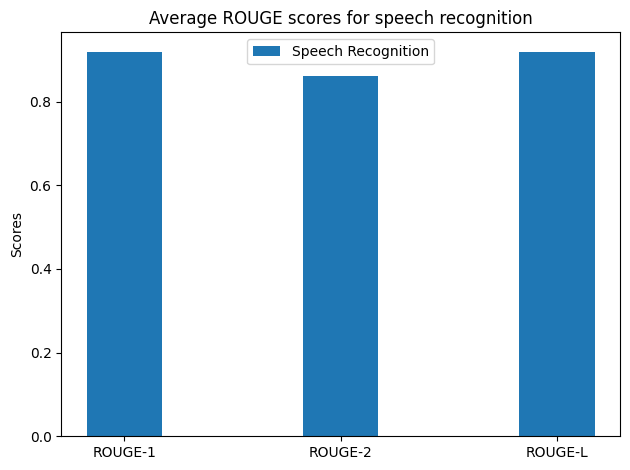

In [44]:
transcriptR = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\wavFiles\\367-130732.trans.txt"
transcriptG = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\wavFiles\\TranscriptObtained.txt"
transcriptions_real = read_transcriptions(transcriptR)
transcriptions_generated = read_transcriptions(transcriptG)

# Evaluate ROUGE scores
evaluate_rouge_scores(transcriptions_generated, transcriptions_real) 

## Generate transcriptions for second experiment

In [21]:
audio_folder = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\notCleanWavFiles"  # Update with your folder path
output_file = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\notCleanWavFiles\\transcriptG.txt"
process_audio_files(audio_folder, output_file)


KeyboardInterrupt: 

Average ROUGE-1 F1 score: 0.7655562973744792
Average ROUGE-2 F1 score: 0.7480449056525611
Average ROUGE-L F1 score: 0.7655562973744792


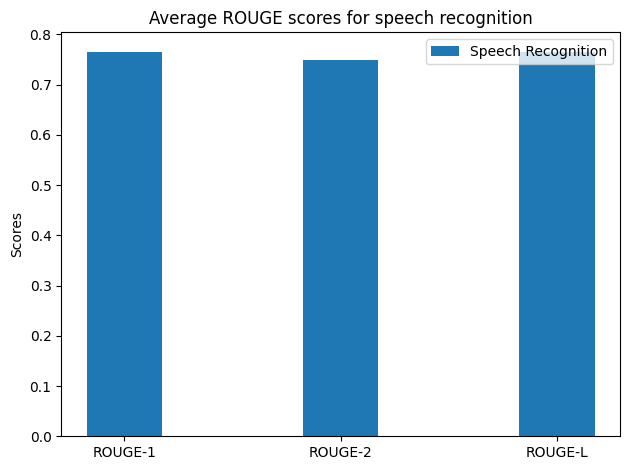

In [43]:
transcriptR = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\notCleanWavFiles\\transcriptR.txt"
transcriptG = "C:\\Users\\Usuario\\Documents\\Project_2-2_Group-5\\src\\main\\python\\notCleanWavFiles\\transcriptG.txt"
transcriptions_real = read_transcriptions(transcriptR)
transcriptions_generated = read_transcriptions(transcriptG)

evaluate_rouge_scores(transcriptions_generated, transcriptions_real)